In [1]:
import jax
# ESTA ES LA FORMA CORRECTA
import jax 
from jax import config
# Habilitar 64-bit float precision
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import lax, random, jit, vmap
from functools import partial
from jax.scipy.stats import norm
from jax.example_libraries import optimizers
from jax.example_libraries.stax import Dense, Relu, serial
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
n = 6 # número de partículas
dim = 2 # dimensiones del espacio (2D)

i, j = np.triu_indices(n, k=1) # índices para calcular interacciones únicas entre partículas (i < j)
q = jnp.array([1, 1, 1, -1, -1, -1])   # cargas de las partículas (3 positivas, 3 negativas)

In [3]:

def energy_fun(x, n, dim, q, k_trap=1.0, k_coul=1.0, eps=1e-6): # Potencial total para partículas cargadas
    # x: (n*dim,)
    X = jnp.reshape(x, (n, dim)) # Reshape del vector de posiciones a una matriz (n, dim)                 
    dX = X[:, None, :] - X[None, :, :]  # Diferencias de posición entre partículas (i, j) -> (n, n, dim)          
    r = jnp.linalg.norm(dX, axis=-1)  # Distancia entre partículas (i, j)            
    r_ij = jnp.sqrt(r[i, j]**2 + eps**2) # Distancia entre pares (i, j) con suavizado para evitar singularidades         

    qq = q[i] * q[j]  # Producto de cargas para cada par (i, j)                            
    V_pair = jnp.sum(k_coul * qq / r_ij) # Atracción/repulsión coulombiana

    V_ext = k_trap * jnp.sum(X**2) # Trampa parabólica de potencial externo
    return V_ext + V_pair # Potencial total = externo + coulombiano

In [4]:
def energy_wrapped(x, n, dim):# Envolver la función de energía para usar solo x como entrada
    return energy_fun(x, n, dim, q=q, k_trap=1.0, k_coul=1.0)

# Modelo generativo #


In [5]:

def layer (transform): # Crear una capa de flujo normalizante a partir de una función de transformación dada
    def init_fun(rng, input_dim): # Inicializar los parámetros de la capa y definir las funciones directa e inversa
        cutoff = input_dim // 2
        perm = jnp.arange(input_dim)[::-1]
        params, trans_fun = transform(rng, cutoff, 2 * (input_dim - cutoff))

        def direct_fun(params, inputs): # Transformación directa, aplicando la permutación a las entradas
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            st = trans_fun(params, lower)
            log_weight, bias = jnp.split(st, 2 , axis =-1)
            upper = upper * jnp.exp(log_weight) + bias

            outputs = jnp.concatenate([lower, upper], axis=1)
            log_det_jacobian = log_weight.sum(-1)
            return outputs[:,perm], log_det_jacobian

        def inverse_fun(params, inputs): # Inversa de la transformación, aplicando la permutación inversa a las entradas
            inputs = inputs[:, perm]
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            st = trans_fun(params, lower)
            log_weight, bias = jnp.split(st, 2 , axis =-1)
            upper = (upper - bias) * jnp.exp(-log_weight)

            outputs = jnp.concatenate([lower, upper], axis=1)
            log_det_jacobian = - log_weight.sum(-1)
            return outputs, log_det_jacobian

        return params, direct_fun, inverse_fun

    return init_fun

# Real NVP #

In [6]:
def RealNVP(transform, n: int): # Crear un flujo normalizante RealNVP con n capas, utilizando la función de transformación dada

    def init_fun(rng, input_dim): # Inicializar los parámetros de todas las capas y definir las funciones directa e inversa para el flujo completo

        all_params, direct_funs, inverse_funs = [], [], []
        for _ in range(n):
            rng, layer_rng = random.split(rng)
            init_fun = layer(transform)
            param, direct_fun, inverse_fun = init_fun(layer_rng, input_dim)

            all_params.append(param)
            direct_funs.append(direct_fun)
            inverse_funs.append(inverse_fun)

        def feed_forward(params, apply_funs, inputs): # Función auxiliar para aplicar secuencialmente las transformaciones directa o inversa a través de todas las capas
            log_det_jacobians = jnp.zeros(inputs.shape[:1])
            for apply_fun, param in zip(apply_funs, params):
                inputs, log_det_jacobian = apply_fun(param, inputs)
                log_det_jacobians += log_det_jacobian
            return inputs, log_det_jacobians

        def direct_fun(params, inputs): # Transformación directa a través de todas las capas, aplicando las funciones directas en orden
            return feed_forward(params, direct_funs, inputs)

        def inverse_fun(params, inputs): # Transformación inversa a través de todas las capas, aplicando las funciones inversas en orden inverso
            return feed_forward(reversed(params), reversed(inverse_funs), inputs)

        return all_params, direct_fun, inverse_fun

    return init_fun

# Fución de costos # 

In [7]:
def make_reinforce_loss(flow_inverse, n, dim, beta): # Crear la función de pérdida REINFORCE para entrenar el flujo normalizante, utilizando la función de energía y la entropía de la distribución transformada

    batch_energy = vmap(energy_wrapped, (0, None, None), 0)# Vectorizar la función de energía para aplicarla a un batch de muestras, manteniendo n y dim constantes

    def loss(params, outputs):# Calcular la pérdida REINFORCE para un batch de muestras transformadas (outputs), utilizando la función de energía y la entropía de la distribución transformada
        inputs, log_det_jacobian = flow_inverse(params, outputs)
        log_prob = norm.logpdf(inputs).sum(-1)
        entropy = log_prob + log_det_jacobian
        energy = batch_energy(outputs, n, dim)
        f = entropy/beta +  energy
        f = lax.stop_gradient(f)

        f_mean = jnp.mean(f)
        f_std = jnp.std(f)/jnp.sqrt(f.shape[0])

        return jnp.mean((f - f_mean) * entropy), (f_mean, f_std)
    return loss


# Inicialización 


In [15]:
batchsize = 8500 # Tamaño del batch para el entrenamiento
n = 6
dim = 2
beta = 10.0 # Parámetro de temperatura para equilibrar energía y entropía en la función de pérdida REINFORCE
nlayers = 2 # Número de capas en el flujo normalizante RealNVP
rng = random.PRNGKey(42) # Semilla para generación de números aleatorios

def transform(rng, cutoff: int, other: int): # Función de transformación para las capas del flujo normalizante, que define una red neuronal simple con dos capas ocultas y activaciones ReLU
            net_init, net_apply = serial(Dense(16), Relu, Dense(16), Relu, Dense(other))
            in_shape = (-1, cutoff)
            out_shape, net_params = net_init(rng, in_shape)
            return net_params, net_apply

flow_init = RealNVP(transform, nlayers) # Inicializar el flujo normalizante RealNVP con la función de transformación dada y el número de capas especificado

init_rng, rng = random.split(rng) # Dividir la semilla para obtener una nueva semilla para la inicialización del flujo normalizante
params, flow_forward, flow_inverse = flow_init(init_rng, n*dim)



In [16]:
loss = make_reinforce_loss(flow_inverse, n, dim, beta) # Crear la función de pérdida REINFORCE para entrenar el flujo normalizante
value_and_grad = jax.value_and_grad(loss, argnums=0, has_aux=True)

In [17]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)# Configurar el optimizador Adam para actualizar los parámetros del flujo normalizante durante el entrenamiento
opt_state = opt_init(params)

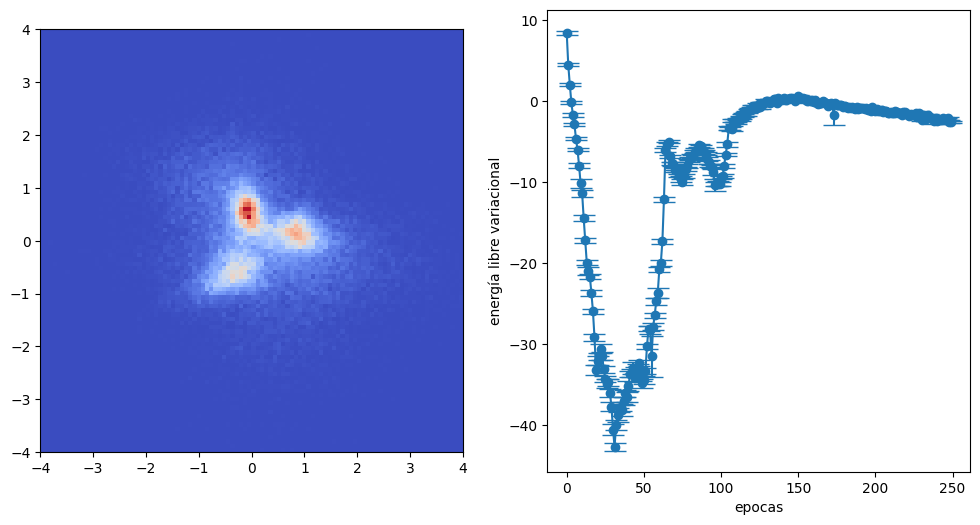

[Array(-2.56505343, dtype=float64), Array(0.14628857, dtype=float64)]


In [18]:
@jit # Compilar la función de entrenamiento para mejorar el rendimiento durante el entrenamiento
def step(rng, i, opt_state):
    params = get_params(opt_state)

    batch_inputs = jax.random.normal(rng, (batchsize, n*dim))
    outputs, _ = flow_forward(params, batch_inputs)

    value, grad = value_and_grad(params, outputs)

    opt_state = opt_update(i, grad, opt_state)
    return value, opt_state, outputs

loss_history = [] # Lista para almacenar el historial de pérdidas durante el entrenamiento
for i in range(250): # Bucle de entrenamiento para actualizar los parámetros del flujo normalizante durante varias iteraciones
    step_rng, rng = jax.random.split(rng)
    value, opt_state, x = step(step_rng, i, opt_state)
    _, (f_mean, f_err) = value

    loss_history.append([f_mean, f_err]) # Almacenar la pérdida media y su error estándar en el historial de pérdidas
    print(f_mean, f_err)

    x = jnp.reshape(x, (batchsize*n, dim)) # Reshape de las muestras transformadas a una matriz (batchsize*n, dim) para visualización

    display.clear_output(wait=True) # Limpiar la salida para actualizar la visualización en cada iteración

    fig = plt.figure(figsize=(12, 6)) # Crear una figura para visualizar la distribución de partículas y el historial de pérdidas
    plt.subplot(1, 2, 1)
    H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1],
                                       bins=100,
                                       range=((-4, 4), (-4, 4)),
                        density=True)
    plt.imshow(H, interpolation="nearest",
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
               cmap="coolwarm")

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    plt.subplot(1, 2, 2)
    y = np.reshape(np.array(loss_history), (-1, 2))
    plt.errorbar(np.arange(i+1), y[:, 0], yerr=y[:, 1], marker='o', capsize=8)
    plt.xlabel('epocas')
    plt.ylabel('energía libre variacional')
    plt.pause(0.01)
print(loss_history[-1])


# energía del sistema despues de la optimmización.


In [19]:

sample_realnvp = x.reshape(batchsize, n, dim)
energy_realnvp = vmap(energy_wrapped, (0, None, None), 0)(sample_realnvp, n, dim)
print(jnp.mean(energy_realnvp), jnp.std(energy_realnvp)/jnp.sqrt(batchsize))


5000011.7093004305 0.06926811363544391


# MCMC 

In [20]:

@partial(jit, static_argnums=0)
def mcmc(logp_fn, x_init, key, mc_steps, mc_width):
    """
        Markov Chain Monte Carlo sampling algorithm.

    INPUT:
        logp_fn: callable that evaluate log-probability of a batch of configuration x.
            The signature is logp_fn(x), where x has shape (batch, n, dim).
        x_init: initial value of x, with shape (batch, n, dim).
        key: initial PRNG key.
        mc_steps: total number of Monte Carlo steps.
        mc_width: size of the Monte Carlo proposal.

    OUTPUT:
        x: resulting batch samples, with the same shape as `x_init`.
    """
    def step(i, state):
        x, logp, key, num_accepts = state
        key, key_proposal, key_accept = jax.random.split(key, 3)
        
        x_proposal = x + mc_width * jax.random.normal(key_proposal, x.shape)
        logp_proposal = logp_fn(x_proposal)

        ratio = jnp.exp((logp_proposal - logp))
        accept = jax.random.uniform(key_accept, ratio.shape) < ratio

        x_new = jnp.where(accept[:, None, None], x_proposal, x)
        logp_new = jnp.where(accept, logp_proposal, logp)
        num_accepts += accept.sum()
        return x_new, logp_new, key, num_accepts
    
    logp_init = logp_fn(x_init)

    x, logp, key, num_accepts = jax.lax.fori_loop(0, mc_steps, step, (x_init, logp_init, key, 0.))
    batch = x.shape[0]
    accept_rate = num_accepts / (mc_steps * batch)
    return x, accept_rate

In [21]:

@partial(jax.vmap, in_axes=(None, 0, None, None))
def logp(beta, x, n, dim):
    return -beta * energy_wrapped(x, n, dim)

In [22]:
mc_steps = 100 
mc_width = 0.05

init_rng, rng = random.split(rng)

x = random.normal(init_rng, (batchsize, n, dim))

for _ in range(20):
    mcmc_rng, rng = random.split(rng)
    x, acc = mcmc(lambda x: logp(beta, x, n, dim), x, mcmc_rng, mc_steps, mc_width)
    e = vmap(energy_wrapped, (0, None, None), 0)(x, n, dim)
    print (acc, jnp.mean(e), jnp.std(e)/jnp.sqrt(batchsize))



0.39926235294117646 4999893.108267447 3.364170505475101
0.1382035294117647 4999728.480966697 7.4755090064101255
0.026298823529411763 4999601.8283376945 8.295745142028952
0.005392941176470588 4999514.000383937 8.800343199370488
0.0030011764705882354 4999439.33656725 9.724801232722498
0.0023094117647058823 4999368.060878358 10.627470137799223
0.001828235294117647 4999306.902365117 11.366730766632875
0.0016094117647058824 4999243.947715823 13.918895743390646
0.0014035294117647058 4999188.028551301 14.838788372599101
0.0011917647058823529 4999143.221268805 15.108230082765838
0.001096470588235294 4999096.2097654035 15.335848202813745
0.0009188235294117647 4999053.454765144 15.857262626104436
0.0008976470588235294 4999018.262643301 15.992657912688424
0.0007964705882352941 4998978.583839851 16.333017389192364
0.000808235294117647 4998937.599792862 16.788202518927992
0.0006717647058823529 4998895.592872093 17.330205114147414
0.0006105882352941176 4998860.718403118 18.427081215585222
0.00059764

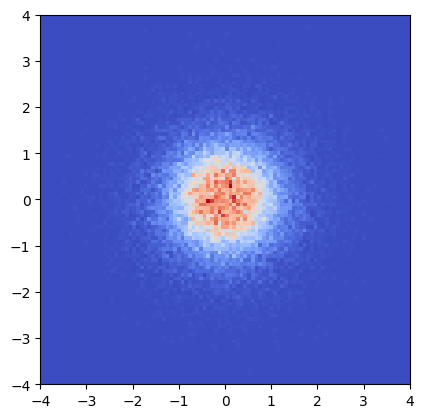

In [23]:
x = jnp.reshape(x, (batchsize*n, dim)) 
#density plot
H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], 
                                       bins=100, 
                                       range=((-4, 4), (-4, 4)),
                        density=True)

plt.imshow(H, interpolation="nearest", 
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
               cmap="coolwarm")


# Optimizando la energía del estado base

In [24]:
energy_rng, rng = random.split(rng)
x_init = jax.random.normal(energy_rng, (n, dim))

energy_and_grad = jax.value_and_grad(energy_fun)

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-1)
opt_state = opt_init(x_init)

In [25]:
def energy_optimize(rng, i, opt_state):
    x_new = get_params(opt_state)
    energy, grad = energy_and_grad(x_new, n, dim, q = q, k_trap=1.0, k_coul=1.0, eps=1e-6)

    opt_state = opt_update(i, grad, opt_state)
    return energy, opt_state, x_new

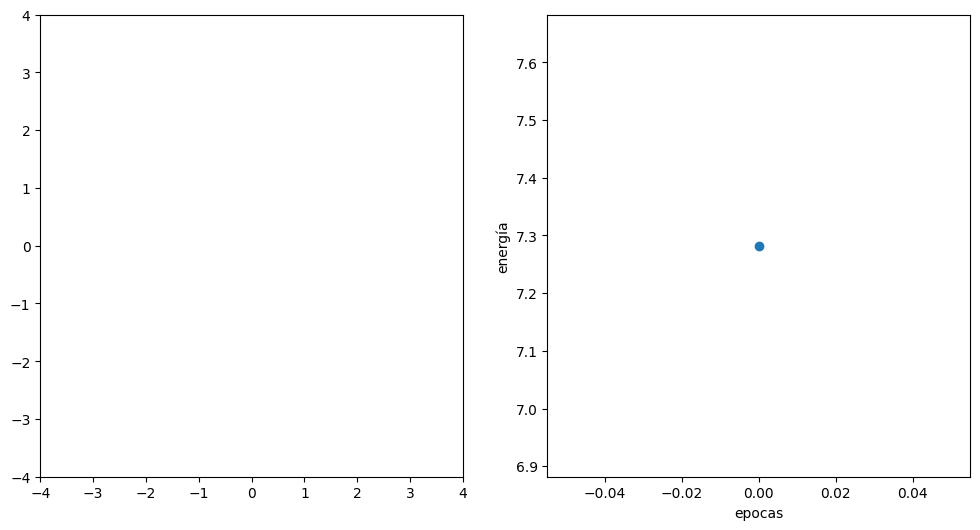

nan


In [26]:
energy_history = []
for i in range(200):
    step_rng, rng = jax.random.split(rng)
    value, opt_state, x = energy_optimize(step_rng, i, opt_state)

    energy_history.append([value])

    display.clear_output(wait=True)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(x[:, 0], x[:, 1])

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    plt.subplot(1, 2, 2)
    y = np.array(energy_history)
    plt.errorbar(np.arange(i+1), y, marker='o', capsize=8)
    plt.xlabel('epocas')
    plt.ylabel('energía')
    plt.pause(0.01)

print(value)

# Colapso del modelo sin un núcleo repulsivo 

Al intentar optimizar la enregía del el estado base del sistema, en r cuando se va a 0 algunas partículas comienzan a intentar ocupar el mismo sitio por atracción, y la energía se va a menos infinito, es necesario agregar un núcleo repulsivo o inicializar las particulas estando separadas con un penalización para efvitar que esto ocurra